<a href="https://colab.research.google.com/github/pepes97/relation-extraction/blob/sveva-develop/Relation_Extraction_Multiclasses_Pretrained_Lemmas_Backup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [1]:
!pip install transformers
!pip install datasets
!pip install sentencepiece
!pip install gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.0 MB/s eta 0:00:00


# Librerie

In [2]:
import re
import os
import torch
import random
import gdown
import json
import numpy as np
from torch import nn
import torch.optim as optim
from itertools import count
from tabulate import tabulate
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
from datasets import load_dataset
from collections import Counter
import nltk
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import recall_score, f1_score, accuracy_score
from torch.nn import Module, Embedding, Dropout, Linear,LSTM
from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer, BertModel
from transformers import XLMRobertaTokenizer, XLMRobertaModel
from transformers import ElectraTokenizer, ElectraModel
device = 'cuda' if torch.cuda.is_available() else 'cpu'

nltk.download('wordnet')
nltk.download('punkt')

seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data

## Data Semeval

In [ ]:
dataset = load_dataset('sem_eval_2010_task_8')

Generating train split:   0%|          | 0/8000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2717 [00:00<?, ? examples/s]

Dataset sem_eval_2010_task_8 downloaded and prepared to /root/.cache/huggingface/datasets/sem_eval_2010_task_8/default/1.0.0/8545d1995bbbade386acf5c4e2bef5589d8387ae0a93356407dfb54cdb234416. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

### Lista delle entità

In [ ]:
def lista_tutte_entità_nel_dataset(data, lista_entita):
  relation_dict = {i: label for i, label in enumerate(data.features['relation'].names)}
  for s, r in zip(data['sentence'], data['relation']):
    if relation_dict[r] != "Other":
      tipo1, tipo2 = relation_dict[r].split("(")[0].split("-")
      lista_entita.append(tipo1)
      lista_entita.append(tipo2)
  return list(set(lista_entita))

### Creazione dati

In [ ]:
def create_data(new_data, data, count_yes, lista_entities, max_len=1864):
  relation_dict = {i: label for i, label in enumerate(data.features['relation'].names)}
  for s, r in zip(data['sentence'], data['relation']):
    soup = BeautifulSoup(s, 'html.parser')
    entita = {}
    for tag in soup.find_all(['e1', 'e2']):
        entita[tag.name] = tag.string
        tag.replace_with(entita[tag.name])
    nuova_frase = str(soup)
    entities = ['O']*len(nuova_frase.split())
    if relation_dict[r]== "Other":
        relation = []
        tipo1, tipo2 = random.sample(lista_entities, 2)
        tipo_entita = {"e1": tipo1, "e2": tipo2}

        for e in entita.keys():
          for i, elem in enumerate(entita[e].split()):
            index_char = nuova_frase.index(elem)
            index_token = nuova_frase[:index_char].count(" ")
            if i == 0:
              entities[index_token] = "B-"+tipo_entita[e]
            else:
              entities[index_token] = "I-"+tipo_entita[e]

        item = {"sentence": nuova_frase,
          "features": nltk.word_tokenize(nuova_frase),
          "entities": entities,
          "relations": relation}
        new_data.append(item)
    else:
      if count_yes < max_len:
        tipo_soggetto, tipo_oggetto = relation_dict[r].split("(")[0].split("-")
        soggetto = relation_dict[r].split('(')[1].split(',')[0]
        oggetto = relation_dict[r].split('(')[1].split(',')[1].split(")")[0]
        tipo_entita = {soggetto: tipo_soggetto, oggetto: tipo_oggetto}

        for e in entita.keys():
          for i, elem in enumerate(entita[e].split()):
            index_char = nuova_frase.index(elem)
            index_token = nuova_frase[:index_char].count(" ")
            if i == 0:
              entities[index_token] = "B-"+tipo_entita[e]
            else:
              entities[index_token] = "I-"+tipo_entita[e]
        relation = [(entita[soggetto], entita[oggetto], relation_dict[r])]
        count_yes+=1
        item = {"sentence": nuova_frase,
          "features": nltk.word_tokenize(nuova_frase),
          "entities": entities,
          "relations": relation}
        new_data.append(item)
  return new_data, count_yes

#### Generazione train,valid, test

In [ ]:
def generate_train_valid_test(data):
  count_yes = 0
  new_data = []
  lista_entita = []
  train = data['train']
  test = data['test']
  lista_entita = lista_tutte_entità_nel_dataset(train, lista_entita)
  lista_entita = lista_tutte_entità_nel_dataset(test, lista_entita)
  new_data, count_yes = create_data(new_data, train, count_yes, lista_entita, max_len= 100000000000)
  new_data, count_yes = create_data(new_data, test, count_yes, lista_entita, max_len= 100000000000)
  return new_data

In [ ]:
data = generate_train_valid_test(dataset)

## Divisione Train, Valid, Test

In [ ]:
def divide_dataset(data):
  # Calcola il numero di istanze per ogni etichetta
  label_counts = {}
  count_labels = 0
  for item in data:
    relation = item["relations"]
    if len(relation) != 0:
      count_labels += 1
      for r in relation:
        if r[2] in label_counts.keys():
          label_counts[r[2]] += 1
        else:
          label_counts[r[2]] = 1
    else:
      count_labels += 1
      if "No-Relations" in label_counts.keys():
        label_counts["No-Relations"] += 1
      else:
        label_counts["No-Relations"] = 1

  # Definiamo la proporzione di dati per ogni set
  train_ratio = 0.7
  val_ratio = 0.15
  test_ratio = 0.15

  # Mescoliamo i dati in modo casuale
  random.shuffle(data)

  # Calcola il numero di istanze per ciascuna divisione
  total_instances = sum(label_counts.values())
  train_size = int(train_ratio * total_instances)
  test_size = int(test_ratio * total_instances)
  dev_size = total_instances - train_size - test_size
  # Calcola il numero di istanze per ogni etichetta nella divisione train
  train_label_counts = {label: int(count * train_ratio) for label, count in label_counts.items()}
  # Inizializza le divisioni train, test e dev
  train_set = []
  test_set = []
  val_set = []

  # Dividi il dataset in base alle etichette e alle quantità calcolate
  for item in data:
      relation = item["relations"]
      if len(relation) != 0:
        for r in relation:
          if train_label_counts[r[2]] > 0:
              train_set.append(item)
              train_label_counts[r[2]] -= 1
          elif test_size > 0:
              test_set.append(item)
              test_size -= 1
          else:
              val_set.append(item)
              dev_size -= 1
      else:
        if train_label_counts["No-Relations"] > 0:
            train_set.append(item)
            train_label_counts["No-Relations"] -= 1
        elif test_size > 0:
            test_set.append(item)
            test_size -= 1
        else:
            val_set.append(item)
            dev_size -= 1
  return train_set, val_set, test_set

train_set, val_set, test_set = divide_dataset(data)
# Verifichiamo le lunghezze dei set per assicurarci che siano corrette
print(len(train_set), len(val_set), len(test_set))

7492 1618 1607


In [ ]:
import json
with open('train.json', 'w') as fout:
  fout.write(json.dumps(train_set))
with open('test.json', 'w') as fout:
  fout.write(json.dumps(test_set))
with open('val.json', 'w') as fout:
  fout.write(json.dumps(val_set))

# Load train, dev, test json

In [4]:
# a file
url_train = "https://drive.google.com/uc?id=1SpZQAtW6Uj0RBR1P5HoO7EfcJ-FTuUc5"
url_valid = "https://drive.google.com/uc?id=1vFRNrs5nrYOLswgKep1txYCv353jE9gr"
url_test = "https://drive.google.com/uc?id=19BD7xVZeifOHvwxQbzkaxinRgkxy_O3l"

train_json = "train.json"
valid_json = "valid.json"
test_json = "test.json"

gdown.download(url_train, train_json, quiet=False)
gdown.download(url_valid, valid_json, quiet=False)
gdown.download(url_test, test_json, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1SpZQAtW6Uj0RBR1P5HoO7EfcJ-FTuUc5
To: /content/train.json
100%|██████████| 3.52M/3.52M [00:00<00:00, 178MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vFRNrs5nrYOLswgKep1txYCv353jE9gr
To: /content/valid.json
100%|██████████| 756k/756k [00:00<00:00, 81.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=19BD7xVZeifOHvwxQbzkaxinRgkxy_O3l
To: /content/test.json
100%|██████████| 750k/750k [00:00<00:00, 95.8MB/s]


'test.json'

In [5]:
train_set = json.load(open("train.json", 'r', encoding="utf-8"))
val_set = json.load(open("valid.json", 'r', encoding="utf-8"))
test_set = json.load(open("test.json", 'r', encoding="utf-8"))

# Statistiche Dati

## Labels

In [ ]:
def count_labels(data):
  relations = []
  for d in data:
    r = d["relations"]
    if len(r)!=0:
      for rr in r:
        relations.append(rr[2])
    else:
      relations.append("No-Relations")
  return relations

In [ ]:
r = count_labels(test_set)

## Histogramma

In [ ]:
def plot_histogram(data: list) -> None:
    # function to add value labels
    def addlabels(x,y):
      for i in range(len(x)):
          plt.text(i, y[i], y[i], ha = 'center', bbox = dict(facecolor = 'red', alpha =.8))

    data_counter = Counter(data)
    x = np.arange(len(data_counter))
    y = [n_elems for _, n_elems in data_counter.items()]
    plt.figure(figsize=(20,5))
    plt.bar(x, y)
    addlabels(x, y)
    plt.xticks(x, [elem_name for elem_name, _ in data_counter.items()], rotation=60)
    plt.show()

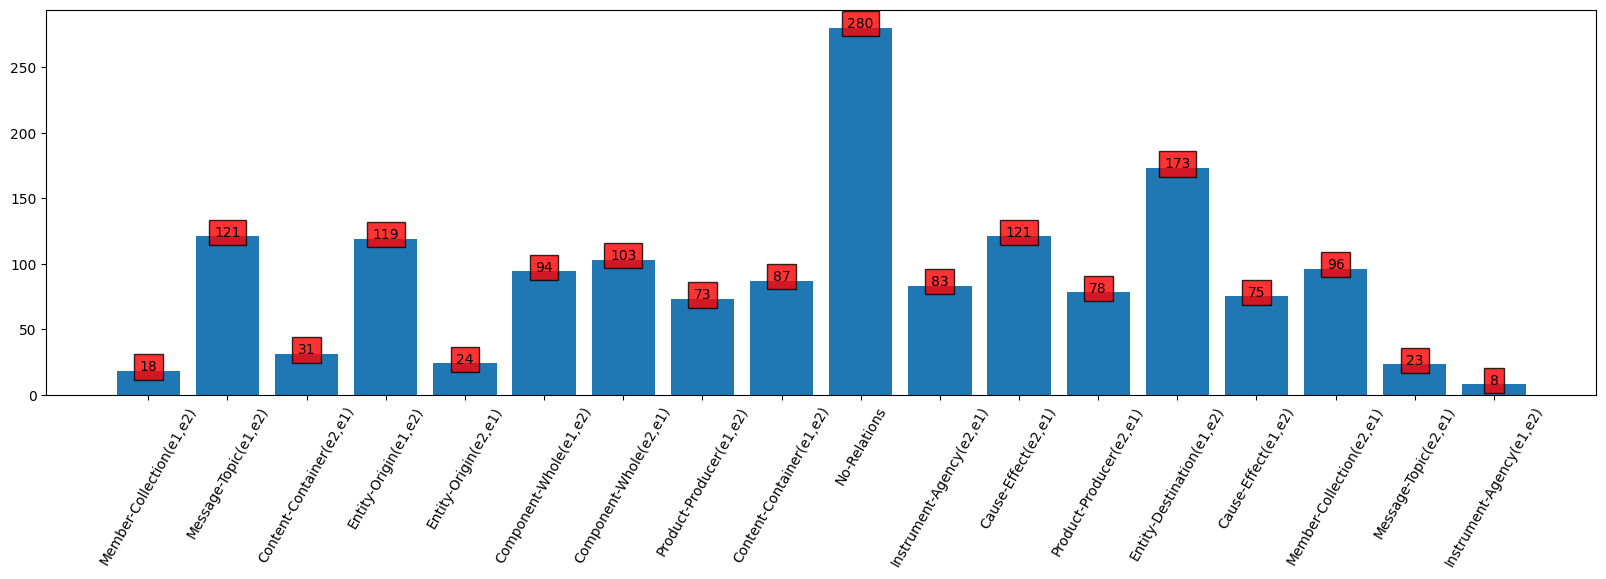

In [ ]:
plot_histogram(r)

# Dataset

In [6]:
class RelationExtraction_MultiClasses_Dataset(Dataset):
  def __init__(self,
                 data,
                 tokenizer, rel2idx = None, ent2idx = None, w_vocab = None, lemma_vocab= None):
    self.data = data
    self.tokenizer = tokenizer
    self.single_sentences = self.rewrite_sentences()
    if rel2idx == None:
      self.rel2idx = self.build_dictionary_relations()
    else:
      self.rel2idx = rel2idx
    if ent2idx == None:
      self.ent2idx = self.build_dictionary_entities()
    else:
      self.ent2idx = ent2idx
    if w_vocab == None:
      self.w_vocab = self.build_vocab_words()
    else:
      self.w_vocab = w_vocab

    if lemma_vocab == None:
      self.lemma_vocab = self.build_vocab_lemma()
    else:
      self.lemma_vocab = lemma_vocab

  def select_only_entities_in_relations(self, elem, new_d, d):
    for m in re.finditer(elem, new_d['sentence']):
      start_id, end_id = m.span()
      token_start_id = new_d['sentence'][:start_id].count(" ")
      token_end_id = new_d['sentence'][:end_id].count(" ")
      for i in range(token_start_id, token_end_id+1):
        new_d['entities'][i] = d['entities'][i]
    return new_d

  def build_vocab_words(self):
    w_dict = {}
    counter = Counter()
    for elem in self.single_sentences:
      for w in elem["features"]:
        counter[w]+=1
    w_dict.update({'<pad>': 0})
    w_dict.update({'<unk>': 1})
    for index, (key,value) in enumerate(counter.most_common()):
      w_dict.update({key: index+2})

    return w_dict

  def build_vocab_lemma(self):
    lemma_dict = {}
    counter = Counter()
    for elem in self.single_sentences:
      for lemma in elem["lemmas"]:
        counter[lemma]+=1
    lemma_dict.update({'<pad>': 0})
    lemma_dict.update({'<unk>': 1})
    for index, (key,value) in enumerate(counter.most_common()):
      lemma_dict.update({key: index+2})
    return lemma_dict

  def lemmatize_sentence(self, sentence):
    # Tokenizzazione della frase
    tokens = nltk.word_tokenize(sentence)
    # Creazione dell'istanza del lematizzatore
    lemmatizer = WordNetLemmatizer()
    # Lemmatizzazione dei token
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmas

  def rewrite_sentences(self):
    # riscrivo il dizionario dove ho una relazione (una tupla) per frase
    new_data = []
    for d in self.data:
      if len(d['relations'])>0:
        for r in d['relations']:
          subj = r[0]
          obj = r[1]
          new_d = d.copy()
          sentence = new_d["sentence"]
          lemmas = self.lemmatize_sentence(sentence)
          new_d['lemmas'] = lemmas
          new_d['relations'] = r
          new_d['entities'] = ['O' for _ in d['entities']]  # reset entities to "O" tags
          new_d = self.select_only_entities_in_relations(subj, new_d, d)
          new_d = self.select_only_entities_in_relations(obj, new_d, d)
          new_data.append(new_d)
      else:
        new_d = d.copy()
        sentence = new_d["sentence"]
        lemmas = self.lemmatize_sentence(sentence)
        new_d['lemmas'] = lemmas
        new_d['relations'] = ()
        new_data.append(new_d)
    return new_data

  def build_dictionary_entities(self):
    # creazione del dizionario entità -> indice
    ent2idx = {"<pad>": 0,  'O': 1}
    for data_point in self.single_sentences:
      entities = data_point['entities']
      for e in entities:
        if e != "O":
          e = e.split("-")[1]
        if e not in ent2idx.keys():
            ent2idx[e] = len(ent2idx)
    return ent2idx

  def encode_words(self, sentence, offset, vocab):
    data = []
    for elem, (start, end) in  zip(sentence,offset):
      if elem in vocab.keys():
        data.append(vocab[elem])
      else:
        data.append(vocab["<unk>"])
      data+=[0]*(end-start-1)
    return [0] + data + [0]

  def encode_words_BERT(self, features):
    curr_offset = 1
    word_offset = []
    sub_word_idx = []
    for featu in features:
      word_idx = self.tokenizer.convert_tokens_to_ids(self.tokenizer.tokenize(featu))
      sub_word_idx += word_idx
      word_offset.append((curr_offset, curr_offset+len(word_idx)))
      curr_offset += len(word_idx)
    sub_word_idx = self.tokenizer.build_inputs_with_special_tokens(sub_word_idx)
    return sub_word_idx, word_offset

  def encode_NER_entities(self, entities, word_offset):
    entities_encoded = []
    for i, (e, (start, end)) in enumerate(zip(entities, word_offset)):
      if e != "O" and e.split("-")[1] in self.ent2idx.keys():
        tag = e.split("-")[1]
        entities_encoded.append(self.ent2idx[tag])
        entities_encoded+=[self.ent2idx[tag]]*(end-start-1)
      elif e== "O":
        entities_encoded.append(self.ent2idx[e])
        entities_encoded+=[self.ent2idx[e]]*(end-start-1)
    entities_encoded = [self.ent2idx['<pad>']]+entities_encoded+[self.ent2idx['<pad>']]
    return entities_encoded

  def encode_labels(self, tuple_relation):
    if len(tuple_relation) == 0:
      labels = self.rel2idx["No-Relation"]
    else:
      labels = self.rel2idx[tuple_relation[2]]
    return labels

  def build_dictionary_relations(self):
    rel2idx = {}
    counter = Counter()
    for elem in self.single_sentences:
      r = elem["relations"]
      if len(r) == 0:
        counter["No-Relation"]+=1
      else:
        counter[r[2]]+=1
    rel2idx.update({'<pad>': 0})
    for index, (key,value) in enumerate(counter.most_common()):
      rel2idx.update({key: index+1})
    return rel2idx

  def __len__(self):
      return len(self.single_sentences)

  def __getitem__(self, index):
      sentence = self.single_sentences[index]['sentence']
      entities = self.single_sentences[index]['entities']
      features = self.single_sentences[index]['features']
      lemmas = self.single_sentences[index]['lemmas']
      tuple_relation = self.single_sentences[index]['relations']

      # encoding word bert
      sub_word_idx, word_offset = self.encode_words_BERT(features)

      # encoding pretrained words
      pretrained_words = self.encode_words(features, word_offset, self.w_vocab)

      # attention mask
      encoded_sentences = self.tokenizer(sentence, padding=True, truncation = True)
      input_ids = encoded_sentences["input_ids"]
      attention_mask = encoded_sentences["attention_mask"]

      # encoding NER entities
      entities_encoded = self.encode_NER_entities(entities, word_offset)

      # encoding lemma
      encoded_lemmas = self.encode_words(lemmas, word_offset, self.lemma_vocab)

      # encoding labels
      labels = self.encode_labels(tuple_relation)

      item = {
         "input_ids": torch.tensor(input_ids),
         "attention_mask": torch.tensor(attention_mask),
         "lemmas": torch.tensor(encoded_lemmas),
         "entites_encoded": torch.tensor(entities_encoded),
         "pretrained_words": torch.tensor(pretrained_words),
         "labels": torch.tensor([labels])
      }

      return item

## Init dataset

In [7]:
models = ['bert-base-uncased',
          'dbmdz/bert-base-italian-xxl-cased',
          'xlm-roberta-base',
          'dbmdz/electra-base-italian-xxl-cased-discriminator',
          'dslim/bert-base-NER'
          ]

In [ ]:
tokenizer

BertTokenizerFast(name_or_path='dslim/bert-base-NER', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [ ]:
tokenizer

ElectraTokenizer(name_or_path='dslim/bert-base-NER', vocab_size=28996, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [8]:
tokenizer = ElectraTokenizer.from_pretrained(models[4])
train_dataset = RelationExtraction_MultiClasses_Dataset(train_set, tokenizer)
word_vocab = train_dataset.w_vocab
lemma_vocab = train_dataset.lemma_vocab
dict_labels = train_dataset.rel2idx
dict_entities = train_dataset.ent2idx
valid_dataset = RelationExtraction_MultiClasses_Dataset(val_set, tokenizer, dict_labels, dict_entities, word_vocab, lemma_vocab)
test_dataset = RelationExtraction_MultiClasses_Dataset(test_set, tokenizer, dict_labels, dict_entities, word_vocab, lemma_vocab)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'ElectraTokenizer'.


## Esempio elemento dataset

In [ ]:
for i,elem in enumerate(train_dataset):
  sentence_encoded = elem["input_ids"]
  attention_mask = elem["attention_mask"]
  entitites_encoded = elem["entites_encoded"]
  pretrained_words = elem["pretrained_words"]
  lemmas = elem["lemmas"]
  labels = elem["labels"]
  entities_invertito = {valore: chiave for chiave, valore in dict_entities.items()}
  lemmas_invertito = {valore: chiave for chiave, valore in lemma_vocab.items()}
  lab_invertito = {valore: chiave for chiave, valore in dict_labels.items()}
  print(f"idx: {i},\nfrase: {tokenizer.decode(sentence_encoded)}, \
        \ntokens: {tokenizer.convert_ids_to_tokens(sentence_encoded)}\
        \nencoded tokens: {sentence_encoded}, shape: {sentence_encoded.shape} \
        \nattention mask: {attention_mask}, shape: {attention_mask.shape} \
        \npretrained_words: {pretrained_words}, shape: {pretrained_words.shape} \
        \nentities: {[entities_invertito[e.item()] for e in entitites_encoded]}\
        \nencoded entities: {entitites_encoded}, shape: {entitites_encoded.shape}\
        \nlemmas: {[lemmas_invertito[e.item()] for e in lemmas]}\
        \nencoded lemmas: {lemmas}, shape: {lemmas.shape}\
        \nlabels: {lab_invertito[labels.item()]}\
        \nencoded labels: {labels}, shape:{labels.shape}")
  break

idx: 0,
frase: [CLS] As the bus climbed steadily throughrich terraced fields of grain towards the Qilian Shan, layersof mountains enfolded like a weyr of dragons. [SEP],         
tokens: ['[CLS]', 'As', 'the', 'bus', 'climbed', 'steadily', 'through', '##rich', 'terrace', '##d', 'fields', 'of', 'grain', 'towards', 'the', 'Qi', '##lian', 'Shan', ',', 'layers', '##of', 'mountains', 'en', '##fold', '##ed', 'like', 'a', 'we', '##yr', 'of', 'dragons', '.', '[SEP]']        
encoded tokens: tensor([  101,  1249,  1103,  3592,  5998, 11383,  1194, 10886, 18655,  1181,
         3872,  1104,  9478,  2019,  1103, 24357, 15647, 20642,   117,  8798,
        10008,  5000,  4035, 10787,  1174,  1176,   170,  1195, 12577,  1104,
        14744,   119,   102]), shape: torch.Size([33])         
attention mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1]), shape: torch.Size([33])         
pretrained_words: tensor([   0,  133,    2,  635

# Dataloader

In [9]:
def padding_function(elems):
  max_len = 512
  input_ids = [elem["input_ids"] for elem in elems]
  attention_mask = [elem["attention_mask"] for elem in elems]
  pretrained_words = [elem["pretrained_words"] for elem in elems]
  entities = [elem["entites_encoded"] for elem in elems]
  lemmas = [elem["lemmas"] for elem in elems]
  labels = [elem["labels"] for elem in elems]
  input_ids[0] = nn.ConstantPad1d((0, max_len - input_ids[0].shape[0]), 0)(input_ids[0])
  attention_mask[0] = nn.ConstantPad1d((0, max_len - attention_mask[0].shape[0]), 0)(attention_mask[0])
  pretrained_words[0] = nn.ConstantPad1d((0, max_len - pretrained_words[0].shape[0]), 0)(pretrained_words[0])
  entities[0] = nn.ConstantPad1d((0, max_len - entities[0].shape[0]), 0)(entities[0])
  lemmas[0] = nn.ConstantPad1d((0, max_len - lemmas[0].shape[0]), 0)(lemmas[0])
  input_ids = pad_sequence(input_ids, batch_first=True, padding_value = 0)
  attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value = 0)
  pretrained_words = pad_sequence(pretrained_words, batch_first=True, padding_value = 0)
  entities = pad_sequence(entities, batch_first=True, padding_value = 0)
  lemmas = pad_sequence(lemmas, batch_first=True, padding_value = 0)
  labels = torch.stack(labels, dim=0)

  item = {
      "input_ids" : input_ids,
      "attention_mask": attention_mask,
      "entities": entities,
      "pretrained_words": pretrained_words,
      "lemmas": lemmas,
      "labels": labels
  }
  assert(input_ids.shape[1]==max_len)
  return item

## Init dataloader

In [21]:
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [22]:
train_dataloader = DataLoader(train_dataset, batch_size=4, collate_fn=padding_function, shuffle = True, worker_init_fn=np.random.seed(seed))
valid_dataloader = DataLoader(valid_dataset, batch_size=4, collate_fn=padding_function)
test_dataloader = DataLoader(test_dataset, batch_size=4, collate_fn=padding_function)

## Esempio elemento dataloader

In [ ]:
for i,elem in enumerate(train_dataloader):
  sentence_encoded = elem["input_ids"]
  attention_mask = elem["attention_mask"]
  entitites_encoded = elem["entities"]
  pretrained_words = elem["pretrained_words"]
  lemmas = elem["lemmas"]
  labels = elem["labels"]
  entities_invertito = {valore: chiave for chiave, valore in dict_entities.items()}
  lab_invertito = {valore: chiave for chiave, valore in dict_labels.items()}
  print(f"idx: {i},\nfrase: {sentence_encoded}, shape: {sentence_encoded.shape}, \
        \nfrase decoded: {tokenizer.batch_decode(sentence_encoded)}, shape: {sentence_encoded.shape}, \
        \nattention mask: {attention_mask}, shape: {attention_mask.shape}, \
        \npretrained_words: {pretrained_words}, shape: {pretrained_words.shape}, \
        \nentities: {entitites_encoded}, shape: {entitites_encoded.shape}\
        \nlemmas: {lemmas}, shape: {lemmas.shape}\
        \nlabels: {labels}, shape: {labels.shape}")
  break

idx: 0,
frase: tensor([[  101,  1203,  1193,  ...,     0,     0,     0],
        [  101,  1252,  1111,  ...,     0,     0,     0],
        [  101,  1337,  1610,  ...,     0,     0,     0],
        [  101,  1230, 12557,  ...,     0,     0,     0]]), shape: torch.Size([4, 512]),         
frase decoded: ['[CLS] Newly generated pneuroblasts are migrating into the dam. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

# Pretrained

In [10]:
# a file
url_50 = "https://drive.google.com/uc?id=1-3ym1GcV8QwseAJBLY137lpY5etSQlxa"
url_100 = "https://drive.google.com/uc?id=1AnYTq5spjA9C_cZrOZk72AeDbFHS-XnM"
url_200 = "https://drive.google.com/uc?id=1-0o-GNW3ZnUn3Hz80c12otgU2aKaPqHW"
url_300 = "https://drive.google.com/uc?id=1-2Jg3xU-y5km2mlNNXv-eD4fx1_Z1MYI"

file_50 = "glove.6B.50d.txt"
file_100 = "glove.6B.100d.txt"
file_200 = "glove.6B.200d.txt"
file_300 = "glove.6B.300d.txt"

gdown.download(url_50, file_50, quiet=False)
gdown.download(url_100, file_100, quiet=False)
gdown.download(url_200, file_200, quiet=False)
gdown.download(url_300, file_300, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-3ym1GcV8QwseAJBLY137lpY5etSQlxa
To: /content/glove.6B.50d.txt
100%|██████████| 171M/171M [00:03<00:00, 53.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1AnYTq5spjA9C_cZrOZk72AeDbFHS-XnM
To: /content/glove.6B.100d.txt
100%|██████████| 347M/347M [00:01<00:00, 188MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0o-GNW3ZnUn3Hz80c12otgU2aKaPqHW
To: /content/glove.6B.200d.txt
100%|██████████| 693M/693M [00:04<00:00, 170MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-2Jg3xU-y5km2mlNNXv-eD4fx1_Z1MYI
To: /content/glove.6B.300d.txt
100%|██████████| 1.04G/1.04G [00:07<00:00, 136MB/s]


'glove.6B.300d.txt'

In [11]:
class PreTrainedEmbedding():
  def __init__(self,
               path:str,
               dim:int,
               vocab:dict):

    self.path = path
    self.dim = dim
    self.vocab = vocab

    self.dictionary_emb = self.build_dictionary()
    self.weights = self.embedding_weights()

  def build_dictionary(self):

    dictionary = {}
    with open(self.path) as file_:
      for line in file_.readlines():
        data = []
        elem = line.strip().split()
        word = elem[0]
        for i in range (self.dim):
          data.append(float(elem[i+1]))
        dictionary[word]=data
    return dictionary

  def embedding_weights(self):

    embeddings_weights = torch.zeros([len(self.vocab),self.dim])
    random = torch.rand(1,self.dim)[0]

    for elem in self.vocab:
      if elem not in self.dictionary_emb:
        embeddings_weights[self.vocab[elem]] = random
      else:
        embeddings_weights[self.vocab[elem]] = torch.tensor(self.dictionary_emb[elem])

    return embeddings_weights

In [12]:
pre_embeddings = PreTrainedEmbedding("./glove.6B.300d.txt", 300, word_vocab)

# Modello

In [13]:
class RelationExtraction_MultiClasses_Model(Module):
  def __init__(self, hparams):
    super(RelationExtraction_MultiClasses_Model, self).__init__()
    self.transformer = ElectraModel.from_pretrained(hparams.transformer_model)
    self.pretrained_embedding = nn.Embedding(hparams.w_vocab_size, hparams.embedding_dim_pretrained)
    self.NER_embedding = nn.Embedding(hparams.NER_vocab_size, hparams.embedding_dim_NER)
    self.lemma_embedding = nn.Embedding(hparams.lemma_vocab_size, hparams.embedding_dim_lemma)
    self.lstm = LSTM( hparams.embedding_dim_words +
                      hparams.embedding_dim_NER +
                      hparams.embedding_dim_lemma +
                      hparams.embedding_dim_pretrained,
                      hparams.hidden_dim,
                      bidirectional = hparams.bidirectional,
                      num_layers = hparams.num_layers,
                      batch_first = True,
                      dropout = hparams.dropout if hparams.num_layers > 1 else 0
                     )
    self.pretrained_embedding.weight.data.copy_(hparams.pretrained_embeddings.weights)
    lstm_output_dim = hparams.hidden_dim if hparams.bidirectional is False else hparams.hidden_dim * 2
    self.dropout = Dropout(hparams.dropout)
    self.classifier = Linear(lstm_output_dim*hparams.max_len, hparams.num_classes)


  def forward(self, input_ids, mask, NER_e, pretrained, lemma):
    embeddings = self.transformer(input_ids, attention_mask=mask)[0]
    embeddings_pretrained  =self.pretrained_embedding(pretrained)
    embeddings_NER = self.NER_embedding(NER_e)
    embeddings_lemma = self.lemma_embedding(lemma)
    embeddings = torch.cat((embeddings, embeddings_NER, embeddings_lemma, embeddings_pretrained), dim=2) # batch, n_seq, emb_bert + emb_NER
    # embeddings = torch.cat((embeddings, embeddings_NER), dim=2) # batch, n_seq, emb_bert + emb_NER
    o, (h, c) = self.lstm(embeddings) # (batch, n_seq, 512)
    o = self.dropout(o)
    o = o.flatten(start_dim=1) # (batch, n_seq * 512)
    output = self.classifier(o)
    return output

## Hparameters

In [14]:
class HParams():
    def __init__(self, l_vocab, ner_vocab, model, w_vocab, lemma_vocab, seed, pretrained_embeddings = None):
      self.transformer_model = model
      self.NER_vocab_size = len(ner_vocab)
      self.fine_tune = False
      self.pretrained_embeddings = pretrained_embeddings
      self.w_vocab_size = len(w_vocab)
      self.lemma_vocab_size = len(lemma_vocab)
      self.embedding_dim_pretrained = 300
      self.embedding_dim_words = 768
      self.embedding_dim_NER = 100
      self.embedding_dim_lemma = 100
      self.hidden_dim = 256
      self.max_len = 512
      self.seed = seed
      self.num_classes = len(l_vocab)
      self.bidirectional = True
      self.num_layers = 2
      self.dropout = 0.3

## Init Modello

In [15]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [16]:
params = HParams(dict_labels, dict_entities, models[4], word_vocab, lemma_vocab, seed, pretrained_embeddings=pre_embeddings)
model = RelationExtraction_MultiClasses_Model(params).to(device)

You are using a model of type bert to instantiate a model of type electra. This is not supported for all configurations of models and can yield errors.


Some weights of ElectraModel were not initialized from the model checkpoint at dslim/bert-base-NER and are newly initialized: ['encoder.layer.2.attention.self.key.weight', 'encoder.layer.1.attention.self.key.bias', 'encoder.layer.1.attention.self.key.weight', 'encoder.layer.7.output.LayerNorm.bias', 'encoder.layer.3.attention.self.key.weight', 'embeddings.LayerNorm.weight', 'encoder.layer.7.intermediate.dense.weight', 'encoder.layer.5.attention.self.query.bias', 'encoder.layer.8.output.LayerNorm.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.5.intermediate.dense.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.10.attention.self.value.bias', 'encoder.layer.4.attention.self.query.bias', 'encoder.layer.6.attention.self.key.weight', 'encoder.layer.8.attention.output.LayerNorm.bias', 'encoder.layer.11.output.LayerNorm.weight', 'encoder.layer.6.output.LayerNorm.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.7.attention.output.LayerNorm.we

In [ ]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

model1 = RelationExtraction_MultiClasses_Model(params).to(device)

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

model2 = RelationExtraction_MultiClasses_Model(params).to(device)

# Verifica se i pesi iniziali sono gli stessi
weights1 = model1.state_dict()
weights2 = model2.state_dict()

# Confronta i pesi
are_weights_equal = all(torch.equal(weights1[key], weights2[key]) for key in weights1)

if are_weights_equal:
    print("I pesi iniziali sono gli stessi per entrambe le istanze del modello.")
else:
    print("I pesi iniziali sono diversi per le due istanze del modello.")

# Train, Validation, Predict

In [17]:
class Trainer():

  def __init__(
      self,
      model: Module,
      loss_function,
      optimizer,
      tokenizer,
      label_vocab,
      patience,
      save_path,
      metrics_path):

    self.model = model
    self.save_path = save_path
    self.metrics_path = metrics_path
    self.load_best_model_and_metrics()
    self.loss_function = loss_function
    self.optimizer = optimizer
    self.tokenizer = tokenizer
    self.label_vocab = label_vocab
    self.patience = patience
    self.best_valid_f1 = 0.0
    self.best_loss =float('inf')
    self.early_stop_counter = 0


  def save_best_model_and_metrics(self):
    best_metrics = {
        'best_valid_f1': self.best_valid_f1,
        'best_loss': self.best_loss
    }
    torch.save(best_metrics, self.metrics_path)
    torch.save(self.model.state_dict(), self.save_path)
    print(f"New checkpoint created. Model Saved in {self.save_path}\n")
    print(f"New best metrics created. Metrics Saved in {self.metrics_path}\n")

  def load_best_model_and_metrics(self):
      if os.path.exists(self.save_path):
        # Carica lo stato del modello
        state_dict = torch.load(self.save_path)
        self.model.load_state_dict(state_dict)
        print("Load model checkpoint. ")
        best_metrics = torch.load(self.metrics_path)
        self.best_valid_f1 = best_metrics.get('best_valid_f1', 0.0)
        self.best_loss = best_metrics.get('best_loss', float('inf'))
        print(f"Load best metrics, f1: {self.best_valid_f1}, loss: {self.best_loss}")

  def train(self, train_dataset, valid_dataset, epochs:int=1):
    train_loss = 0.0
    for epoch in range(epochs):
      epoch_loss = 0.0
      self.model.train()
      train_iterator = tqdm(train_dataset)
      f1_scores = list()
      accuracies = list()
      y_true, y_pred = [], []
      for step, sample in enumerate(train_iterator):

        input_ids = sample['input_ids'].to(device)
        attention_mask = sample['attention_mask'].to(device)
        pretrained_embeddings = sample['pretrained_words'].to(device)
        entitites = sample['entities'].to(device)
        lemma = sample['lemmas'].to(device)
        labels = sample['labels'].to(device) # (batch, n_classes)

        self.optimizer.zero_grad()

        predictions = self.model(input_ids, attention_mask, entitites, pretrained_embeddings, lemma)
        labels = labels.view(-1)

        sample_loss = self.loss_function(predictions, labels)

        sample_loss.backward()

        self.optimizer.step()

        epoch_loss += sample_loss.item()
        avg_loss = epoch_loss / (step + 1)

        # Calcolo dell'accuratezza nel batch
        pred = torch.argmax(predictions, dim=1)

        # Aggiunta delle etichette vere e predette per calcolare l'F1-score
        y_true.extend(labels.tolist())
        y_pred.extend(pred.tolist())

        f1 = f1_score(labels.tolist(), pred.tolist(), average="weighted", zero_division=0)
        acc = accuracy_score(labels.tolist(), pred.tolist())

        train_iterator.set_postfix(
          loss=avg_loss,
          epoch=epoch,
          f1_score = f1,
          accuracy = acc,
          step=(step + 1)
        )
        f1_scores.append(f1)
        accuracies.append(acc)

      training_metrics = {}
      training_metrics['loss'] = epoch_loss / len(train_dataset) if epoch_loss > 0 else 0.0
      training_metrics['f1'] = sum(f1_scores) / len(f1_scores) if f1_scores else 0.0
      training_metrics['accuracy'] = sum(accuracies) / len(accuracies) if accuracies else 0.0
      validation_metrics = self.evaluate(valid_dataset, epoch)

      keys = set()
      keys |= set(training_metrics.keys())
      keys |= set(validation_metrics.keys())

      table = []

      for key in keys:
          table.append((key, training_metrics.get(key, float('Nan')), validation_metrics.get(key, float('Nan'))))

      print(tabulate(table, headers=('metric', 'train', 'dev')) + '\n')

      # Early stopping check
      valid_f1 = validation_metrics['f1']
      valid_loss = validation_metrics['loss']
      if valid_f1 > self.best_valid_f1 and valid_loss < self.best_loss:
          self.best_valid_f1 = valid_f1
          self.early_stop_counter = 0
          self.best_loss = valid_loss
          if self.save_path is not None:
              self.save_best_model_and_metrics()
              print(f"New checkpoint created. Model Saved in {self.save_path}\n")
      else:
          self.early_stop_counter += 1
          if self.early_stop_counter >= self.patience:
              print("Early stopping triggered. No improvement in validation F1 score.")
              break

  def evaluate(self, valid_dataset, epoch):
    valid_loss = 0.0
    self.model.eval()
    f1_scores = list()
    accuracies = list()
    y_true, y_pred = [], []
    with torch.no_grad():
      valid_iterator = tqdm(valid_dataset)
      for step,  sample in enumerate(valid_iterator):
        input_ids = sample['input_ids'].to(device)
        attention_mask = sample['attention_mask'].to(device)
        pretrained_embeddings = sample['pretrained_words'].to(device)
        entitites = sample['entities'].to(device)
        lemma = sample['lemmas'].to(device)
        labels = sample['labels'].to(device)
        predictions = self.model(input_ids, attention_mask, entitites, pretrained_embeddings, lemma)
        labels = labels.view(-1)
        sample_loss = self.loss_function(predictions, labels)
        valid_loss += sample_loss.tolist()
        avg_loss = valid_loss / (step + 1)

        # Calcolo dell'accuratezza nel batch
        pred = torch.argmax(predictions, dim=1)

        # Aggiunta delle etichette vere e predette per calcolare l'F1-score
        y_true.extend(labels.tolist())
        y_pred.extend(pred.tolist())

        f1 = f1_score(labels.tolist(), pred.tolist(), average="weighted", zero_division=0)
        acc = accuracy_score(labels.tolist(), pred.tolist())

        valid_iterator.set_postfix(
          loss=avg_loss,
          epoch=epoch,
          f1_score = f1,
          accuracy = acc,
          step=(step + 1)
        )

        f1_scores.append(f1)
        accuracies.append(acc)

    metrics = {}
    metrics['loss'] = valid_loss / len(valid_dataset) if valid_loss > 0 else 0.0
    metrics['f1'] = sum(f1_scores) / len(f1_scores) if f1_scores else 0.0
    metrics['accuracy'] = sum(accuracies) / len(accuracies) if accuracies else 0.0

    return metrics

  def predict(self, test_dataset):
    self.model.eval()
    f1_scores = list()
    accuracies = list()
    y_true, y_pred = [], []
    with torch.no_grad():
      test_iterator = tqdm(test_dataset)
      for step,  sample in enumerate(test_iterator):
        input_ids = sample['input_ids'].to(device)
        attention_mask = sample['attention_mask'].to(device)
        pretrained_embeddings = sample['pretrained_words'].to(device)
        entitites = sample['entities'].to(device)
        labels = sample['labels'].to(device)
        lemma = sample['lemmas'].to(device)
        predictions = self.model(input_ids, attention_mask, entitites, pretrained_embeddings, lemma)

        # Calcolo dell'accuratezza nel batch
        pred = torch.argmax(predictions, dim=1)

        # Aggiunta delle etichette vere e predette per calcolare l'F1-score
        y_true.extend(labels.tolist())
        y_pred.extend(pred.tolist())

        f1 = f1_score(labels.tolist(), pred.tolist(), average="weighted", zero_division=0)
        acc = accuracy_score(labels.tolist(), pred.tolist())

        test_iterator.set_postfix(
          f1_score = f1,
          accuracy = acc,
          step=(step + 1)
        )

        f1_scores.append(f1)
        accuracies.append(acc)
    return y_pred, y_true,  sum(f1_scores) / len(f1_scores), sum(accuracies) / len(accuracies)

## Init Trainer

In [18]:
model_path = "/content/drive/MyDrive/relations/models_multiclasses/electra_bert_base_300.pth"
metrics_path = "/content/drive/MyDrive/relations/models_multiclasses/best_metrics_electra_300.pth"

In [23]:
trainer = Trainer(
    model = model,
    loss_function = nn.CrossEntropyLoss(ignore_index=0),
    optimizer = optim.Adam(model.parameters(), lr=2e-5),
    tokenizer = tokenizer,
    label_vocab= dict_labels,
    patience = 1,
    save_path = model_path,
    metrics_path = metrics_path
)

### Training

In [ ]:
trainer.train(train_dataloader, valid_dataloader, 50)

  0%|          | 0/1873 [00:00<?, ?it/s]

  0%|          | 0/405 [00:00<?, ?it/s]

metric       train       dev
--------  --------  --------
accuracy  0.180459  0.194444
f1        0.12525   0.148624
loss      2.65239   2.60051

New checkpoint created. Model Saved in /content/drive/MyDrive/relations/models_multiclasses/electra_bert_base_300.pth

New best metrics created. Metrics Saved in /content/drive/MyDrive/relations/models_multiclasses/best_metrics.pth

New checkpoint created. Model Saved in /content/drive/MyDrive/relations/models_multiclasses/electra_bert_base_300.pth



  0%|          | 0/1873 [00:00<?, ?it/s]

  0%|          | 0/405 [00:00<?, ?it/s]

metric      train       dev
--------  -------  --------
accuracy  0.3433   0.546914
f1        0.31192  0.52821
loss      2.05343  1.24044

New checkpoint created. Model Saved in /content/drive/MyDrive/relations/models_multiclasses/electra_bert_base_300.pth

New best metrics created. Metrics Saved in /content/drive/MyDrive/relations/models_multiclasses/best_metrics.pth

New checkpoint created. Model Saved in /content/drive/MyDrive/relations/models_multiclasses/electra_bert_base_300.pth



  0%|          | 0/1873 [00:00<?, ?it/s]

  0%|          | 0/405 [00:00<?, ?it/s]

metric       train       dev
--------  --------  --------
accuracy  0.667912  0.69321
f1        0.657618  0.689691
loss      0.924579  0.835803

New checkpoint created. Model Saved in /content/drive/MyDrive/relations/models_multiclasses/electra_bert_base_300.pth

New best metrics created. Metrics Saved in /content/drive/MyDrive/relations/models_multiclasses/best_metrics.pth

New checkpoint created. Model Saved in /content/drive/MyDrive/relations/models_multiclasses/electra_bert_base_300.pth



  0%|          | 0/1873 [00:00<?, ?it/s]

  0%|          | 0/405 [00:00<?, ?it/s]

metric       train       dev
--------  --------  --------
accuracy  0.750801  0.77037
f1        0.745861  0.766255
loss      0.648872  0.590847

New checkpoint created. Model Saved in /content/drive/MyDrive/relations/models_multiclasses/electra_bert_base_300.pth

New best metrics created. Metrics Saved in /content/drive/MyDrive/relations/models_multiclasses/best_metrics.pth

New checkpoint created. Model Saved in /content/drive/MyDrive/relations/models_multiclasses/electra_bert_base_300.pth



  0%|          | 0/1873 [00:00<?, ?it/s]

### Predict

In [23]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [24]:
model = RelationExtraction_MultiClasses_Model(params).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

trainer = Trainer(
    model = model,
    loss_function = nn.CrossEntropyLoss(ignore_index=0),
    optimizer = optim.Adam(model.parameters(), lr=2e-5),
    tokenizer = tokenizer,
    label_vocab= dict_labels,
    patience = 5,
    save_path = model_path
)

Load model checkpoint. 


In [25]:
predictions, true_labels, accuracy, f1 = trainer.predict(valid_dataloader)

  0%|          | 0/405 [00:00<?, ?it/s]

In [26]:
print(f"Accuracy test: {accuracy}, Accuracy f1: {f1}")

Accuracy test: 0.7031481481481482, Accuracy f1: 0.7061728395061728


In [27]:
predictions, true_labels, accuracy, f1 = trainer.predict(test_dataloader)

  0%|          | 0/402 [00:00<?, ?it/s]

In [28]:
print(f"Accuracy test: {accuracy}, Accuracy f1: {f1}")

Accuracy test: 0.7147743425728498, Accuracy f1: 0.7139303482587065


In [ ]:
labels_test = [
 'No-Relation',
 'Entity-Destination(e1,e2)',
 'Cause-Effect(e2,e1)',
 'Member-Collection(e2,e1)',
 'Entity-Origin(e1,e2)',
 'Message-Topic(e1,e2)',
 'Component-Whole(e1,e2)',
 'Component-Whole(e2,e1)',
 'Instrument-Agency(e2,e1)',
 'Content-Container(e1,e2)',
 'Product-Producer(e2,e1)',
 'Cause-Effect(e1,e2)',
 'Product-Producer(e1,e2)',
 'Content-Container(e2,e1)',
 'Message-Topic(e2,e1)',
 'Entity-Origin(e2,e1)',
 'Instrument-Agency(e1,e2)',
 'Member-Collection(e1,e2)']

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(true_labels, predictions, target_names = labels_test))

                           precision    recall  f1-score   support

              No-Relation       0.92      0.88      0.90       280
Entity-Destination(e1,e2)       0.98      0.99      0.98       173
      Cause-Effect(e2,e1)       0.90      0.99      0.94       121
 Member-Collection(e2,e1)       0.99      0.95      0.97        96
     Entity-Origin(e1,e2)       0.95      0.99      0.97       119
     Message-Topic(e1,e2)       0.95      0.99      0.97       121
   Component-Whole(e1,e2)       0.93      0.97      0.95        94
   Component-Whole(e2,e1)       0.99      0.91      0.95       103
 Instrument-Agency(e2,e1)       0.99      0.94      0.96        83
 Content-Container(e1,e2)       0.93      0.98      0.96        87
  Product-Producer(e2,e1)       0.96      0.92      0.94        78
      Cause-Effect(e1,e2)       0.96      0.91      0.93        75
  Product-Producer(e1,e2)       0.91      0.97      0.94        73
 Content-Container(e2,e1)       0.96      0.87      0.92     

# Confusion metrics

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):


    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(20, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
cm = confusion_matrix(true_labels, predictions)
plot_confusion_matrix(cm, labels)